# Data Augmentation Experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
#from src.utils import load_combined_dataset
import matplotlib.pyplot as plt

In [18]:
def load_floss_dataset(n_change_points=2):
    desc_filename = "../datasets/FLOSS/desc.txt"
    desc_file = np.genfromtxt(fname=desc_filename, delimiter=',', filling_values=[None], dtype=None, encoding='utf8')

    df = []

    for ts_name, window_size, floss_score, cp_1, cp_2 in desc_file:
        if n_change_points == 1 and cp_2 != -1: continue

        change_points = [cp_1]
        if cp_2 != -1: change_points.append(cp_2)

        ts = np.loadtxt(fname=os.path.join('../datasets/FLOSS/', ts_name + '.txt'), dtype=np.float64)
        df.append((ts_name, window_size, np.array(change_points), ts))

    return pd.DataFrame.from_records(df, columns=["name", "window_size", "change points", "time_series"])


def load_ucrcp_dataset():
    desc_filename = "../datasets/UCRCP/desc.txt"
    desc_file = []

    with open(desc_filename, 'r') as file:
        for line in file.readlines(): desc_file.append(line.split(","))

    df = []

    for row in desc_file:
        (ts_name, window_size), change_points = row[:2], row[2:]

        ts = np.loadtxt(fname=os.path.join('../datasets/UCRCP/', ts_name + '.txt'), dtype=np.float64)
        df.append((ts_name, int(window_size), np.array([int(_) for _ in change_points]), ts))

    return pd.DataFrame.from_records(df, columns=["name", "window_size", "change points", "time_series"])


def load_combined_dataset():
    return pd.concat([load_floss_dataset(), load_ucrcp_dataset()])

In [19]:
def _true_positives(T, X, margin=5):
    '''
    Compute true positives without double counting
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> _true_positives(set(), {1, 2, 3})
    set()
    >>> _true_positives({1, 2, 3}, set())
    set()
    '''
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(ground_truth, predictions, margin=5, alpha=0.5, return_PR=False):
    '''
    Compute the F-measure based on human annotations. Remember that all CP locations are 0-based!
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    :param annotations: dict from user_id to iterable of CP locations
    :param predictions: iterable of predicted CP locations
    :param alpha: value for the F-measure, alpha=0.5 gives the F1-measure
    :return: whether to return precision and recall too
    Examples
    -----------
    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    '''
    annotations =	{'1':ground_truth}
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(_true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: _true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F
def _cover_single(Sprime, S):
    '''
    Compute the covering of a segmentation S by a segmentation Sprime.
    This follows equation (8) in Arbaleaz, 2010.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _cover_single([{1, 2, 3}, {4, 5}, {6}], [{1, 2, 3}, {4, 5, 6}])
    0.8333333333333334
    >>> _cover_single([{1, 2, 3, 4}, {5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2}, {3, 4}, {5, 6}], [{1, 2, 3}, {4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2, 3, 4, 5, 6}], [{1}, {2}, {3}, {4, 5, 6}])
    0.3333333333333333
    '''
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(_overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(ground_truth, predictions, n_obs):
    '''
    Compute the average segmentation covering against the human annotations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    @param annotations: dict from user_id to iterable of CP locations
    @param predictions: iterable of predicted Cp locations
    @param n_obs: number of observations in the series
    Examples
    -----------
    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634
    '''
    annotations =	{'1':ground_truth}
    Ak = {
        k + 1: _partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = _partition_from_cps(predictions, n_obs)

    Cs = [_cover_single(pX, Ak[k]) for k in Ak]
    return sum(Cs) / len(Cs)

def _partition_from_cps(locations, n_obs):
    '''
    Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> _partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> _partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> _partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    '''
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition

def _overlap(A, B):
    '''
    Return the overlap (i.e. Jaccard index) of two sets
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _overlap({1, 2, 3}, set())
    0.0
    >>> _overlap({1, 2, 3}, {2, 5})
    0.25
    >>> _overlap(set(), {1, 2, 3})
    0.0
    >>> _overlap({1, 2, 3}, {1, 2, 3})
    1.0
    '''
    return len(A.intersection(B)) / len(A.union(B))

In [21]:
df_ts = load_combined_dataset()
df_ts

,name,window_size,change points,time_series
0,Cane,100,[2345],"[-0.3205028, -0.37070978, -0.393024, -0.252165..."
1,DutchFactory,24,[2184],"[1022.0, 1038.0, 1036.0, 1026.0, 1039.0, 1046...."
2,EEGRat,10,[1000],"[-0.1671106, -0.035091142, -0.074696981, -0.33..."
3,EEGRat2,10,[1000],"[-1.0569423, -0.90092768, -0.66900428, -0.5340..."
4,Fetal2013,70,"[6000, 12000]","[219.0, 186.0, 157.0, 143.0, 130.0, 119.0, 140..."
...,...,...,...,...
61,UWaveGestureLibraryZ,10,"[600, 1131, 1652, 2193]","[-0.527058, 0.416111, -0.524027, 0.41141, 0.12..."
62,Wafer,20,[115],"[0.193828, -0.53263, 0.578613, -0.290365, 0.13..."
63,WordSynonyms,10,"[202, 2227]","[-1.183581, -0.514028, -0.480539, -0.394855, -..."
64,Worms,10,"[435, 786]","[-0.007806, 0.201876, -0.585311, -0.585897, 0...."


In [22]:
ground_truth = df_ts['change points']
ground_truth = ground_truth.to_numpy()
data = df_ts['time_series']
data = data.to_numpy()
windows = df_ts['window_size']
windows = windows.to_numpy()

# DC-TSS With Augmentation

In [23]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
from scipy.signal import find_peaks, peak_prominences

#from TS_DEC_Linear import *

# DC-TSS With Augmentation

In [ ]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 6000
lr=0.1
pre_lr = 1.5e-3

# DC-TSS hyper-parameters
overlap_percent = 0.6
n_clusters = 10
window_length2 = 100

coverings_with = []

for i,time_series in enumerate(data):
    print(len(time_series))
    time_series = (time_series - np.average(time_series)) / np.std(time_series)
    labels = []
    h = 0
    y = 0
    for j,_ in enumerate(time_series):
        if j == ground_truth[y]:
            y+=1
            h+=1
        labels.append(h)
    l = np.unique(labels)
        
    window_length = windows[i]
    if window_length < 20:
        window_length = 20
        layers = [5,3,2]
        strides = [2,1,1]
    elif window_length > 100:
        window_length = 100
        layers = [15,10,5]
        strides = [2,2,2]
    elif window_length >= 40 and window_length <=80:
        layers = [10,6,4]
        strides = [2,2,2]
    elif window_length < 40:
        layers = [5,3,2]
        strides = [2,1,1]
    elif window_length > 80:
        layers = [10,6,4]
        strides = [2,2,2]
        
    window_length2 = 60
    if window_length2 % 2 == 1:
        window_length2 += 1

    # Subsequence Univariate TS
    start = 0
    subsequences = []
    subsequence_labels = []

    while start+window_length < len(time_series):
        subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
        subsequence = time_series[start:start+window_length]
        start = start+window_length - int(overlap_percent*window_length)
        subsequences.append(subsequence)

    subsequences = np.asarray(subsequences)
    subsequence_labels = np.asarray(subsequence_labels)
    batch_size = len(subsequences)

    subsequences = np.expand_dims(subsequences, axis=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)


    data_loader = get_dataloader(data=subsequences,
                              shuffle=False,
                              batch_size=batch_size,
                              data_transforms=None)
    torch.cuda.empty_cache()
    input_shape = subsequences.shape
    
    deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
    deep_cluster_model.to(device)
    pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)

    # refine mapping
    cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.0, 1)
    print(cluster_assignments)
    while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
        for assignment in range(np.max(cluster_assignments)+1):
            if assignment not in cluster_assignments:
                indx = np.where(cluster_assignments > assignment)
                cluster_assignments[indx] = cluster_assignments[indx]-1
        l = np.unique(cluster_assignments)
    
    window_length2 = int(0.2*len(cluster_assignments))
    if window_length2 % 2 == 1:
        window_length2 += 1
    similarities = get_label_score(cluster_assignments, window_length2)
    try:
        d = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
    except:
        d = similarities
    
    if window_length2 % 2 == 1:
        window_length2 += 1
    d = smooth(np.blackman(30), d)
    peaks, peak_data = find_peaks(d, height=0.6,distance=window_length2//2,prominence=0.15)
    real_peaks = peaks+window_length2//2
    plt.plot(d)
    plt.show()
    predictions = get_changepoints(real_peaks, window_length, overlap_percent)
    print(predictions)
    print(ground_truth[i])
    coverings_with.append(covering(ground_truth[i], predictions, len(time_series)))

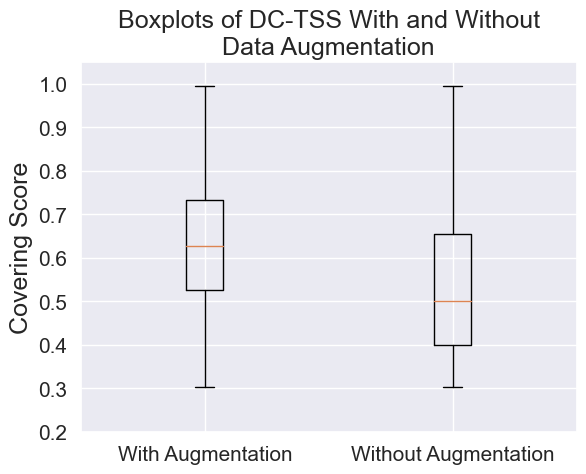

In [94]:
plt.boxplot([coverings_with, coverings_without],  labels=['With Augmentation', 'Without Augmentation'])#, labels=['ClaSP', 'FLOSS', 'DC-TSS'])
plt.title("Boxplots of DC-TSS With and Without\nData Augmentation",fontsize=18)
plt.ylabel("Covering Score", fontsize=18)
plt.ylim(0.2, 1.05)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#plt.xlabel("Methods", fontsize=18)
plt.savefig('boxplot_withandwithout.pdf',dpi=1000)
plt.show()